# 머신러닝 맛보기 2편

__참고:__ 오렐리앙 제롱의 [<핸즈온 머신러닝(2판)>](https://github.com/ageron/handson-ml2) 
4장 1절과 2절의 소스코드를 사용합니다.

## 주요 내용

- 선형회귀
- 경사하강법

## 기본 설정

- 필수 모듈 불러오기
- 그래프 출력 관련 기본 설정 지정

In [1]:
import numpy as np

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## 머신러닝 모델 훈련

머신러닝 모델의 훈련 과정에 필요한 요소는 __모델__과 __훈련 데이터셋__이다.
그리고 모델과 훈련 데이터셋에 따라 훈련 방식이 결정되며, 머신러닝과 딥러닝 분야에서 다양한 훈련 기법을 연구한다.
또한 어떤 모델과 어떤 훈련 데이터셋을 사용하느냐에 따라 모델 훈련의 결과가 매우 달라질 수 있다.
여기서는 간단한 선형회귀 모델의 훈련과정을 구체적으로 살펴보면서 머신러닝 모델 훈련을 소개한다.

### 선형회귀 모델 훈련

먼저 머신러닝 모델 훈련에 사용되는 데이터 훈련 세트는 $m$x$n$ 모양의 2차원 어레이로 표현됨을 기억해야 한다.

- $m$: 훈련 세트 크기, 즉 훈련 데이터 샘플의 개수.
- $n$: 훈련 데이터 샘플의 특성 수.
- $\mathbf{x}_{j}^{(i)}$: $i$ 번째 훈련 입력 데이터 샘플의 $j$번째 특성값.

$$
\mathbf{X}_{\textit{train}} = 
\begin{bmatrix}
\mathbf{x}_{1}^{(1)} & \mathbf{x}_{2}^{(1)} & \cdots & \mathbf{x}_{n}^{(1)}\\
\mathbf{x}_{1}^{(2)} & \mathbf{x}_{2}^{(2)} & \cdots & \mathbf{x}_{n}^{(2)}\\
 & \vdots & \\
\mathbf{x}_{1}^{(m)} & \mathbf{x}_{2}^{(m)} & \cdots & \mathbf{x}_{n}^{(m)}
\end{bmatrix}
$$

아래 코드는 선형회귀 학습과정을 설명하기 위해 사용되는 하나의 특성을 사용하는
간단한 훈련 데이터를 생성한다. 

* `X`: 훈련 세트. 하나의 특성 `x1`을 갖는 100개의 데이터. 즉, $m=100$, $n=1$.
* `y`: 100 개의 레이블. 기본적으로 `4 + 3 * x`의 형식을 따르나 훈련을 위해 잡음(noise)를 추가 했음.

__참고:__ 정규분포를 따르는 부동소수점 100개를 무작위로 생성하여 잡음으로 사용하였다.

In [2]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

In [3]:
X.shape

(100, 1)

In [4]:
y.shape

(100, 1)

특성 `x1`과 레이블 `y`의 관계를 그리면 다음과 같다.
기본적으로 `y = 4 + 3 * x` 의 선형관계를 갖지만 잡음으로 인해 데이터가 퍼져 있다.

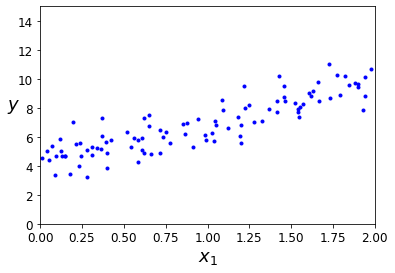

In [5]:
plt.plot(X, y, "b.")                          # 파랑 점: 훈련 세트 산점도
plt.xlabel("$x_1$", fontsize=18)              # x축 표시
plt.ylabel("$y$", rotation=0, fontsize=18)    # y축 표시
plt.axis([0, 2, 0, 15])                       # x축, y축 스케일 지정
plt.show()

### 정규 방정식

아래 식을 만족시키는 최적의 $\theta_0$, $\theta_1$을 찾고자 한다. 

$$
\begin{align*}
y^{(1)} &= \theta_0 + \theta_1 \cdot x_1^{(1)} \\
y^{(2)} &= \theta_0 + \theta_1 \cdot x_1^{(2)} \\
&= \cdots \\
y^{(100)} &= \theta_0 + \theta_1 \cdot x_1^{(100)} 
\end{align*}
$$

이를 행렬식으로 표현하면 다음과 같다.

$$
\begin{bmatrix}
y^{(1)} \\
y^{(2)} \\
\vdots \\
y^{(100)}
\end{bmatrix}
= 
\begin{bmatrix}
1 & \mathbf{x}_{1}^{(1)} \\
1 & \mathbf{x}_{1}^{(2)} \\
 & \vdots \\
1 & \mathbf{x}_{1}^{(m)}
\end{bmatrix}
\cdot
\begin{bmatrix}
\theta_0 \\
\theta_1
\end{bmatrix}
$$

일반화하면 다음과 같다.

$$
\begin{bmatrix}
y^{(1)} \\
y^{(2)} \\
\vdots \\
y^{(100)}
\end{bmatrix}
= 
\begin{bmatrix}
1 & \mathbf{x}_{1}^{(1)} & \mathbf{x}_{2}^{(1)} & \cdots & \mathbf{x}_{n}^{(1)}\\
1 & \mathbf{x}_{1}^{(2)} & \mathbf{x}_{2}^{(2)} & \cdots & \mathbf{x}_{n}^{(2)}\\
 & & \vdots & \\
1 & \mathbf{x}_{1}^{(m)} & \mathbf{x}_{2}^{(m)} & \cdots & \mathbf{x}_{n}^{(m)}
\end{bmatrix}
\cdot
\begin{bmatrix}
\theta_0 \\
\theta_1\\
\theta_2 \\
\vdots \\
\theta_n \\
\end{bmatrix}
$$

따라서 $\mathbf{y}$와 $\mathbf{X}$가 주어졌을 때 아래 식을 만족시키는 벡터 $\hat{\boldsymbol{\theta}}$를 구해야 한다. 

$$
\mathbf{y} = \mathbf{X} \,\hat{\boldsymbol{\theta}}
$$

만약에 $(\mathbf{X}^T \mathbf{X})^{-1}$의 역행렬이 존재하고 실제로 일정 시간 내에 계산이 가능하다면 최적의 
파라미터 조합 $\boldsymbol{\hat\theta}$ 를 아래 정규 방정식으로 직접 구할 수 있다.

$$
\hat{\boldsymbol{\theta}} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}
$$

아래 코드는 위 정규 방정식을 위에서 생성한 훈련 세트에 대해 계산한다.

* `np.ones((100, 1))`: 절편 $\theta_0$를 고려하기 위해 훈련세트의 0번 열에 추가되는 `x0=1`로 이루어진 벡터
* `X_b`: 모든 샘플에 대해 `x0=1`이 추가된 어레이

__주의사항:__ 1 벡터를 추가하는 일은 여기서만 설명을 위해 사용된다. 
사이킷런의 모델을 사용할 때는 모델이 알아서 처리해준다.

In [6]:
X_b = np.c_[np.ones((100, 1)), X]  # 모든 샘플에 x0 = 1 추가
X_b[:5]

array([[1.        , 0.74908024],
       [1.        , 1.90142861],
       [1.        , 1.46398788],
       [1.        , 1.19731697],
       [1.        , 0.31203728]])

In [7]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

계산된 $\boldsymbol{\hat\theta} = [\theta_0, \theta_1]$ 은 다음과 같다.

In [8]:
theta_best

array([[4.21509616],
       [2.77011339]])

계산된 $\boldsymbol{\hat\theta}$ 를 이용하여 `x1=0`과 `x1=2`일 때의 예측값 $\hat y$는 단순한 행렬 곱셈에 불과하다.

$$\hat{y} = \mathbf{X}\, \boldsymbol{\hat{\theta}}$$

예측을 위해서도 먼저 `x0=1` 열을 추가해야 한다.

__주의사항:__ $\mathbf{X}$ 와 $\hat\theta$ 의 순서에 너무 민감해할 필요는 없다.
설명하는 방식에 따라 순서가 바뀌거나 전치행렬이 사용될 뿐이며, 결과는 모두 동일하다.

In [9]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # 모든 샘플에 x0 = 1 추가
X_new_b

array([[1., 0.],
       [1., 2.]])

행렬 곱셈에 의한 예측값은 다음과 같다.

In [10]:
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

$\theta_0$ 을 절편으로, $\theta_1$ 을 기울기로 하는 직선은 아래와 같다.

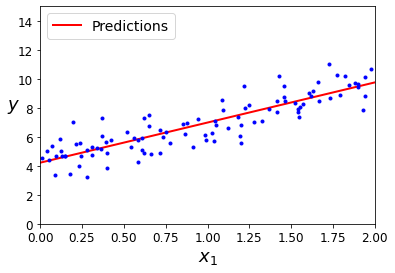

In [11]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions") # 빨강 직선. label은 범례 지정용

plt.plot(X, y, "b.")                                               # 파란 점: 훈련 세트 산점도
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)

plt.legend(loc="upper left", fontsize=14)                          # 범례 위치
plt.axis([0, 2, 0, 15])                                            # x축, y축 스케일 지정

plt.show()

### 사이킷런의 `LinearRegression` 모델

`LinearRegression` 모델은 특잇값 분해(SVD) 방식을 이용하여 계산된 무어-펜로즈의 유사 역행렬 $\mathbf{X}^+$를 
이용하여 파라미터 $\hat\theta$를 계산한다.

$$
\hat{\boldsymbol{\theta}} = \mathbf{X}^+ \mathbf{y}
$$

훈련된 모델의 `intercept_`와 `coef_` 속성에 절편 $\theta_0$ 과 기울기 $\theta_1$ 이 저장된다.

In [12]:
import sklearn

In [13]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

`x1=0`과 `x1=2`에 대한 예측값과 앞서 수동으로 계산된 값과 동일하다.

In [14]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

&#x270b; 무어-펜로즈의 유사 역행렬 $\mathbf{X}^{+}$ 는 `np.linalg.pinv()`을 사용해서 구해지며,
이를 위 수식처럼 이용하면 동일한 최적 파라미터를 구한다.

In [15]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

## 경사 하강법

앞선 언급한 무어-펜로즈 유사 역행렬을 구하는 알고리즘의 계산 복잡도는 $O(n^2)$이다.
즉 특성 수가 늘어날 수록 계산 시간은 제곱 지수승으로 늘어난다.
따라서 많은 수의 특성을 사용하는 데이터에 대해서는 SVD 방식을 사용하는 
사이킷런의 `LinearRegrssion` 모델을 사용할 수 없으며
배치 경사 하강법에 기반한 모델을 대신 사용해야 한다.

### 배치 경사 하강법

임의로 지정된 파라미터 $\boldsymbol{\hat\theta}$로 시작한 후에
비용 함수(MSE)가 작아지는 방향으로 조금씩 파라미터를 조정한다.

$$
\begin{align*}
\mathrm{MSE}(\theta) & = \mathrm{MSE}(\mathbf X, h_\theta) \\
 & = \frac 1 m \sum_{i=1}^{m} \big(\hat y^{(i)} - y^{(i)}\big)^2 \\[2ex]
\hat y^{(i)} & = \theta^{T}\, \mathbf{x}^{(i)} \\
 & = \theta_0 + \theta_1\, \mathbf{x}_1^{(i)} + \cdots + \theta_n\, \mathbf{x}_n^{(i)}
\end{align*}
$$

파라미터를 조정할 때 사용하는 기준은 비용 함수의 그레이디언트 벡터의 방향과 크기이다.

$$
\nabla_\theta \text{MSE}(\boldsymbol{\theta})
 = \frac{2}{m}\, \mathbf{X}^T (\mathbf{X} \boldsymbol{\theta} - \mathbf{y})
$$

파라미터 조정은 아래 방식으로 이루어진다. 단, $\eta$는 학습률을 가리킨다.

$$
\boldsymbol{\theta}^{(\text{next step})} = \boldsymbol{\theta}^{(\text{previous step})} - \eta\cdot \nabla_\theta \text{MSE}(\boldsymbol{\theta})
$$

아래 코드는 $\theta_0$과 $\theta_1$을 무작위로 지정한 다음에
앞서 언급한 학습률 조정 과정을 수동으로 1,000번 진행한 결과를 보여준다.

In [16]:
eta = 0.1                     # 학습률
n_iterations = 1000           # 1000번 파라미터 조정
m = 100                       # 샘플 수

theta = np.random.randn(2,1)  # 파라미터 무작위 초기화

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)   # 비용 함수 그레이디언트
    theta = theta - eta * gradients                   # 파라미터 업데이트

앞서 얻은 결과와 동일한 최적의 파라미터가 계산된다.

In [17]:
theta

array([[4.21509616],
       [2.77011339]])

#### 학습률과 모델 학습

&#x270b; 아래 코드는 학습률에 따라 파라미터 학습과정이 어떻게 달라질 수 있는지를 보여주기 위해
세 개의 그래프를 그려준다.

- `theta_path_bgd` 변수: 배치 경사 하강법에서 조정되는 파라미터를 순처적으로 저장하는 용도의 리스트. 
    아래에서 세 종류의 경사 하강법을 비교하는 그림에서 활용됨.
- `plot_gradient_descent()` 함수: 선형회귀 모델 훈련 과정의 처음 10단계를 보여주는 도표 그려주는 함수.

In [18]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")    # 훈련 세트 산점도
    
    n_iterations = 1000     # 1000번 반복 훈련
    for iteration in range(n_iterations):
        
        # 초반 10번 선형 모델(직선) 그리기
        if iteration < 10:                         
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        
        # 파라미터 조정
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        
        # 조정되는 파라미터를 모두 리스트에 저장 (theta_path=None 옵션이 아닌 경우)
        if theta_path is not None:
            theta_path.append(theta)
            
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

파랑 직선은 초반 10번의 모델 학습과정을 보여준다.
학습률(`eta`)에 따라 학습 과정이 많이 다를 수 있음을 잘 보여준다.

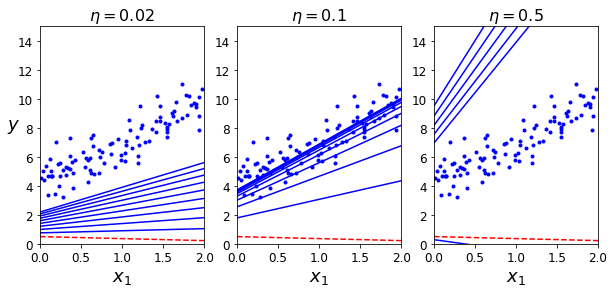

In [19]:
np.random.seed(42)
theta = np.random.randn(2,1)  # 무작위 초기화

plt.figure(figsize=(10,4))    # 도표 크기 지정

# eta=0.02
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)

# eta=0.1
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)

# eta=0.5
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

__참고:__ 사이킷런은 배치 경사 하강법을 지원하는 모델을 제공하지 않는다.

### 확률적 경사 하강법

아래 코드는 확률적 경사 하강법의 작동 과정을 보여주는 코드이다.

* `theta_path_sgd` 변수: 확률적 경사 하강법에서 조정되는 파라미터를 순처적으로 저장하는 용도의 리스트. 
    아래에서 세 종류의 경사 하강법을 비교하는 그림에서 활용됨.

In [20]:
theta_path_sgd = []

m = len(X_b)
np.random.seed(42)

* `n_epochs=50`: 총 50번의 에포크 기간동안 훈련 진행
* `t0` 과 `t1`: 학습 스케줄을 위한 하이퍼파라미터 역할 수행

In [21]:
n_epochs = 50   # 에포크 수
t0, t1 = 5, 50  # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

모델이 수렴값 근처에서 진동하는 것을 확인할 수 있다.

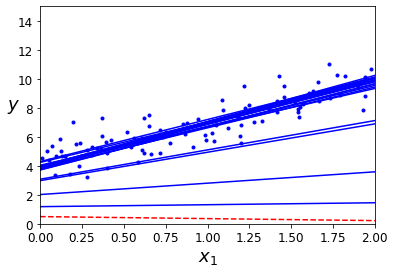

In [22]:
theta = np.random.randn(2,1)    # 파라미터 랜덤 초기화

for epoch in range(n_epochs):
    
    # 매 샘플에 대해 그레이디언트 계산 후 파라미터 업데이트
    for i in range(m):
        
        # 처음 20번 선형 모델(직선) 그리기
        if epoch == 0 and i < 20:                    
            y_predict = X_new_b.dot(theta)           
            style = "b-" if i > 0 else "r--"         
            plt.plot(X_new, y_predict, style)        
            
        # 파라미터 업데이트
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)  # 하나의 샘플에 대한 그레이디언트 계산
        eta = learning_schedule(epoch * m + i)        # 학습 스케쥴을 이용한 학습률 조정
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 

plt.plot(X, y, "b.")                                 
plt.xlabel("$x_1$", fontsize=18)                     
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, 0, 15])                              
plt.show()                                           

그렇지만 50번만의 에포크 만으로 상당히 좋은 파라미터를 찾는다.

In [23]:
theta

array([[4.21076011],
       [2.74856079]])

#### 사이킷런의 `SGDRegressor` 모델

`SGDRegressor` 모델은 확률적 경사 하강법을 사용하며 따라서 매우 빠르게 학습한다.

In [24]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [25]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

### 미니배치 경사 하강법

아래 코드는 크기 20인 배치를 활용하는 미니배치 경사 하강법을 구현한다.

* `theta_path_mgd` 변수: 미니배치 경사 하강법에서 조정되는 파라미터를 순처적으로 저장하는 용도의 리스트. 
    아래에서 세 종류의 경사 하강법을 비교하는 그림에서 활용됨.
    
* `n_iterations = 50`: 에포크 수 50
* `minibatch_size = 20`: 배치 크기 20

In [26]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

학습 스케줄이 사용된 미니배치 수 `t`에 의존한다.

* `t`: 훈련에 사용된 미니배치 개수. 학습 스케줄에 사용됨.

In [27]:
t = 0

for epoch in range(n_iterations):
    
    # 에포크가 바뀔 때마다 훈련 데이터 섞기
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    
    # 20개 데이터 샘플을 훈련할 때마다 파라미터 업데이트
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)        # 학습 스케줄 활용
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [28]:
theta

array([[4.25214635],
       [2.7896408 ]])

### 배치/확률적/미니배치 경사 하강법 파라미터 학습과정 비교

아래 코드는 아래 세 개의 변수에 저정된 파라미터 값들을 도표로 보여준다. 

* 파랑선: 배치 경사 하강법의 경우이며 최적의 파라미터에 제대로 수렴한다.
* 빨강선: 확률적 경사 하강법의 경우이며 최적의 파라미터에 근처에서 심하게 요동친다.
* 초록선: 미니배치 경사 하강법의 경우이며 최적의 파라미터에 근처에서 상대적으로 덜 요동친다.

In [29]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

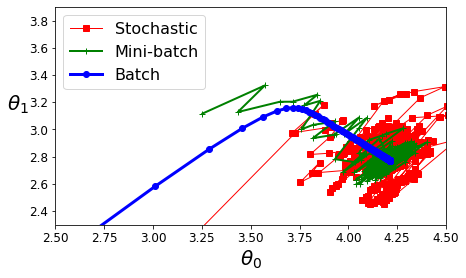

In [30]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])

plt.show()